<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Somethings to change**:

1.  find the eigen point correspoing mode, W and PC relation

2.  Make the analysis more stable by using last three weights

3.  Try to find decoding performance in 10-50 setting

4.  Use more range to measure not only 15 55 85

5.  Same trends of increasing img, but failed prediction, what is other factors?  What really predicts the limit cycle type strategy? 

6.  Relation of PC dimension and real trace shape, if too high D will make the real game hard? 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import pandas as pd

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

import dynamics
from dynamics import * 

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/cruiser/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

Training from zero seems to be better because it will allow the agent to explore from new

In [2]:
class PretrainTest():
    def __init__(self, weight_read, holes = 0, inputs_type = (1, 0), size = 15):
        self.pregame = PretrainGame(grid_size = (15, 15), holes = holes, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[0])
        self.pregame.net.load_state_dict(torch.load(weight_read))
        self.game = ValueMaxGame(self.pregame.net, grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[1])
        self.weight = weight_read
        
            
    def decode(self, weight = None):
        if weight != None:
            self.pregame.net.load_state_dict(torch.load(weight))
        else:
             self.pregame.net.load_state_dict(torch.load(self.weight))
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        self.game.net.cpu()
        self.game.experiment(rls_q, rls_sl,20, epsilon = 0.5, train_hidden = False, train_q = False, size_range=(15, 16), test = True) 
        def precision():
            prec0 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0)[0] + decodetest(self.game, reward_control = 1,  epsilon = 0)[0])
            prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0.5)[0] + decodetest(self.game, reward_control =  1,  epsilon = 0.5)[0])
            prec2 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 1)[0] + decodetest(self.game, reward_control =  1,  epsilon = 1)[0])
            return (prec0 + prec1 + prec2)/3, (prec2 - prec0)
        print ('decode train finish')
        Prec, dif = precision()
        print ('decode end', Prec, 'dif decode', dif)
        return Prec, dif
        # q learning session 
    
    
    def TestAllSizes(self, size_range = np.arange(15, 86, 10)):
        self.pregame.net.load_state_dict(torch.load(self.weight))
        self.game.net.cpu()
        self.Performance = []
        for size in size_range:
            Rewards0 = Test(self.game, reward_control = 0, size = size, test = size//25)
            Rewards1 = Test(self.game, reward_control = 1, size = size, test = size//25)
            self.Performance.append((Rewards0 + Rewards1)/2)

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **

## Spectre

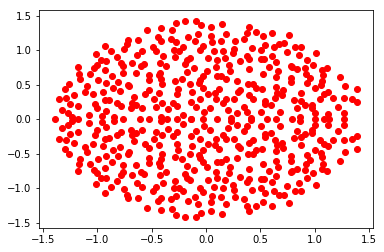

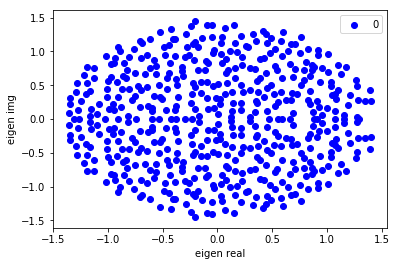

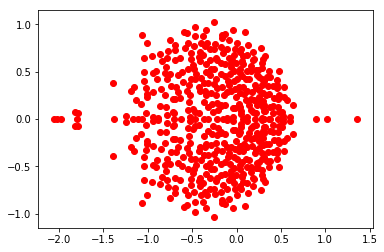

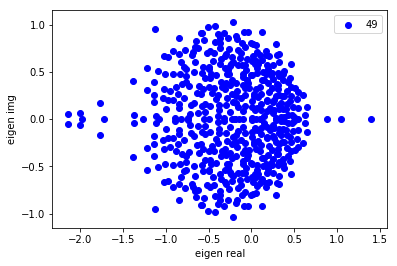

In [3]:
dWs = []
for iters, trial in enumerate(np.arange(0, 50, 49)):
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
    game.net.load_state_dict(torch.load('weights_pre2/rnn_1515tanh512_checkpoint{}'.format(trial)))
    game.net.h2o = nn.Parameter(torch.randn(512, 4) * 1 * np.sqrt(2.0/(512+4)))
    if iters == 0:
        W0 = game.net.h2h 
    W = game.net.h2h 
    dWs.append(W - W0)
    Weff = game.net.h2h + game.net.h2o.matmul(game.net.a2h)
    plt.figure()
    plt.scatter (W.eig()[0][:,0].data.numpy(), W.eig()[0][:,1].data.numpy(), label = trial, color = 'r')
    plt.figure()
    plt.scatter (Weff.eig()[0][:,0].data.numpy(), Weff.eig()[0][:,1].data.numpy(), label = trial, color = 'b')
    
    plt.legend()
#     plt.xlim(-2, 2)
#     plt.ylim(-3, 3)

    plt.xlabel('eigen real')
    plt.ylabel('eigen img')
    plt.savefig('eigen{}'.format(trial))
#     print (Weff)

dw 41.71 w 26.8251


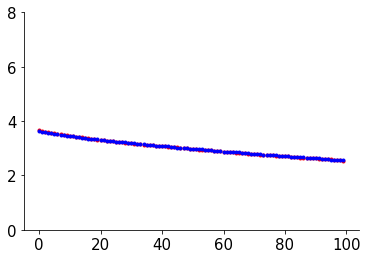

In [4]:

W = torch.load('weights_net1/rnn_1515tanh512_checkpoint{}_0_9'.format(49))['h2h'].cpu()
dW = (W - W0.cpu()).data.numpy()
print ('dw', np.linalg.norm(dW), 'w', np.linalg.norm(W))
dW_shuffle = np.random.permutation(dW.ravel()).reshape(512, 512)
u, s, vh = np.linalg.svd(dW)
u_shuffle, s_shuffle, vh_shuffle = np.linalg.svd(dW_shuffle)
if trial == 49:
    ax = subplot(1, 1, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.plot(s[:100],'r.')
    plt.plot(s_shuffle[:100],'b.')
    plt.xticks(size = 15)
    plt.yticks([0, 2, 4, 6, 8], size = 15)

In [154]:
W[:0, :0]

array([], shape=(0, 0), dtype=float32)

If look carefully, the slow timescale here is a very long transient,  it will not return to baseline in a very long run of game, that is different from gru, which maintains a baseline.  If the system is a true integrator,  it should not loose the baseline, because there is no concept of return in this case. 

The very slow timescale could make the system harder to reset, except I use a strong input.  So reset upon input and remember is always contradictory.  If I design a task also need to pay attention to fast timescale , this will fail more throughly 

# Timescale, Spatial Information & Performance

**There is change associate with the pretraining, but if coupling all factors and use short stimlus pulses, there is no big effect**

**charaterize the system by timescale in this case, and input - output correlation with random action, use these two parameters to predict learning** 

**Another approach is the random readout compare,  the specific readout is related to one network, if we look at things statistically, something related to Whh will truly reveal.  The distribution also permits us to give continouse number as probability of bi-stability**

**Characterize the limit cycle by period and shape/complexity/dimension of wave**

In [30]:
weight = 'weights_net1/rnn_1515tanh512_checkpoint49_0_9'
pca = PCA(weight)
pca.pca(T_duration = 5)

In [31]:
pca.Dynamics(Actions = [0, 1, 2, 3], legend = True, T_total = 200, T_stim = 100, T_duration = 3, readout_random = False, open_loop = True, 
)

tensor(4.4374)


([], <a list of 0 Text yticklabel objects>)

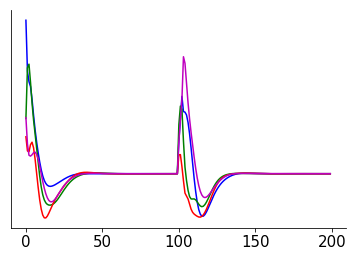

In [32]:
# long dynamics for different stimulus
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
colors = ['b', 'g', 'r', 'm', 'c']
for i in range(4):
    c = colors[i]
    for j in range(1):
        plt.plot(pca.PCs[i, j], color = c)
print (torch.norm(pca.game.placefield(pca.game.pos_reward).matmul(pca.game.net.r2h)))
plt.xticks([0, 50, 100, 150, 200], size = 15)
plt.yticks([])

In [36]:
Fix_points = []   
for i in range(4):
    hidden = np.zeros(512)
    for j in range(4):
           hidden += pca.Hiddens[i, j, -1]
    hidden = hidden/4
    Fix_points.append(hidden)
np.save('fix_points', Fix_points)

for hf1 in Fix_points:
    for hf2 in Fix_points:
          print  (np.linalg.norm(hf1 - hf2))

tensor(4.5434)
tensor(5.4422)


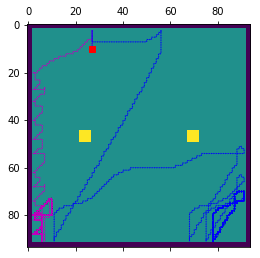

In [33]:
size = 90
PC_traces = []
torch.manual_seed(190)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (10, 27)
    weight ='weights_net1/rnn_1515tanh512_checkpoint49_0_9'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    for pos in game.Set_reward:
        grid[pos[0]-3: pos[0]+3, pos[1]-3: pos[1]+3]
    Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 3, init_hidden = False, hidden = hidden)
    print (torch.norm(game.placefield(game.pos_reward).matmul(game.net.r2h)))
    Pos2, hidden2, dH2, Action, State2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 3, init_hidden = False, hidden = hidden)
    print (torch.norm(game.placefield(game.pos_reward).matmul(game.net.r2h)))
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')

(0, 400)

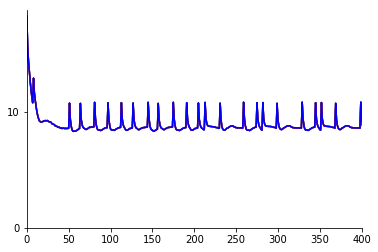

In [39]:
Fix_points = np.load('fix_points.npy')
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
colors = ['b', 'g', 'r', 'b', 'c']
for i, hf in enumerate(Fix_points):
    distance = []
    for hidden in hidden1:
        distance.append(np.linalg.norm(hf - hidden))
#     plt.figure()
    plt.plot(distance, color = colors[i])
# plt.xticks([0, 50, 100, 150], size = 15)
plt.yticks([0, 10])
plt.xlim(0, 400)

**what is the relation between close loop and open loop analysis?**

longer time, there is no pheonmean associate with multi-stability

Here with action feedback, dynamics shift to a totally different regime which is around hopf bifurcation, but it is not hugely shaped by the stimulus

From this graph of PC, we will see that the representation states of trajectory (3,5) and (14,5) are actually qutie close to each other , reflecting symmetry in real space, it is in spirit of predictive decoding, using least number of interal states to play well. 

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**